In [2]:
#!pip install pyomo
#!pip install rich
#!apt-get install coinor-cbc
#!pip install networkx
%load_ext autoreload
%autoreload 2

# QUESTÃO 1. 
Uma empresa possui duas unidades fabris cujos resíduos sólidos devem ser incinerados e depois dispostos em aterros sanitários. A unidade fabril 1 produz 500 toneladas de resíduos por mês, enquanto a unidade 2 produz 400 toneladas por mês. Há dois incineradores terceirizados, ambos com capacidades de incinerar 500 toneladas por mês. O custo por tonelada no incinerador 1 é de R$ 40,00, enquanto no incinerador 2 é de R$ 30,00. Após incinerados, os resíduos tornam-se detritos com apenas 20% da sua massa inicial. Os detritos resultantes da incineração são dispostos em 2 aterros sanitários públicos. Cada um dos aterros pode receber até 200 toneladas por mês da empresa. A empresa também deve pagar o transporte dos resíduos para serem incinerados e em seguida dispostos nos aterros, ao custo de R$3,00/km/ton. A tabela abaixo exibe as distâncias (em km) entre as unidades fabris e os incineradores, bem como a distância entre os incineradores e os aterros.

<table>
<tr><th colspan="2" >Distâncias </tr>
<tr><td>

|             | Incinerador |    |
|:-----------:|:-----------:|:--:|
| Unid. Fabri |      1      |  2 |
|      1      |      30     |  5 |
|      2      |      36     | 42 |

</td><td>

|             | Aterro |    |
|:-----------:|:-----------:|:--:|
| Incinerador |      1      |  2 |
|      1      |      5     |  8 |
|      2      |      9     | 6 |

</td></tr> </table>

1. Formule um modelo de programação linear para este problema de forma a minimizar o custo total da empresa para se dispor dos seus resíduos.
2. Resolva o problema por meio do Excel ou Python Pyomo.

Primeiramente vamos ter uma noção visual do que está acontecendo.

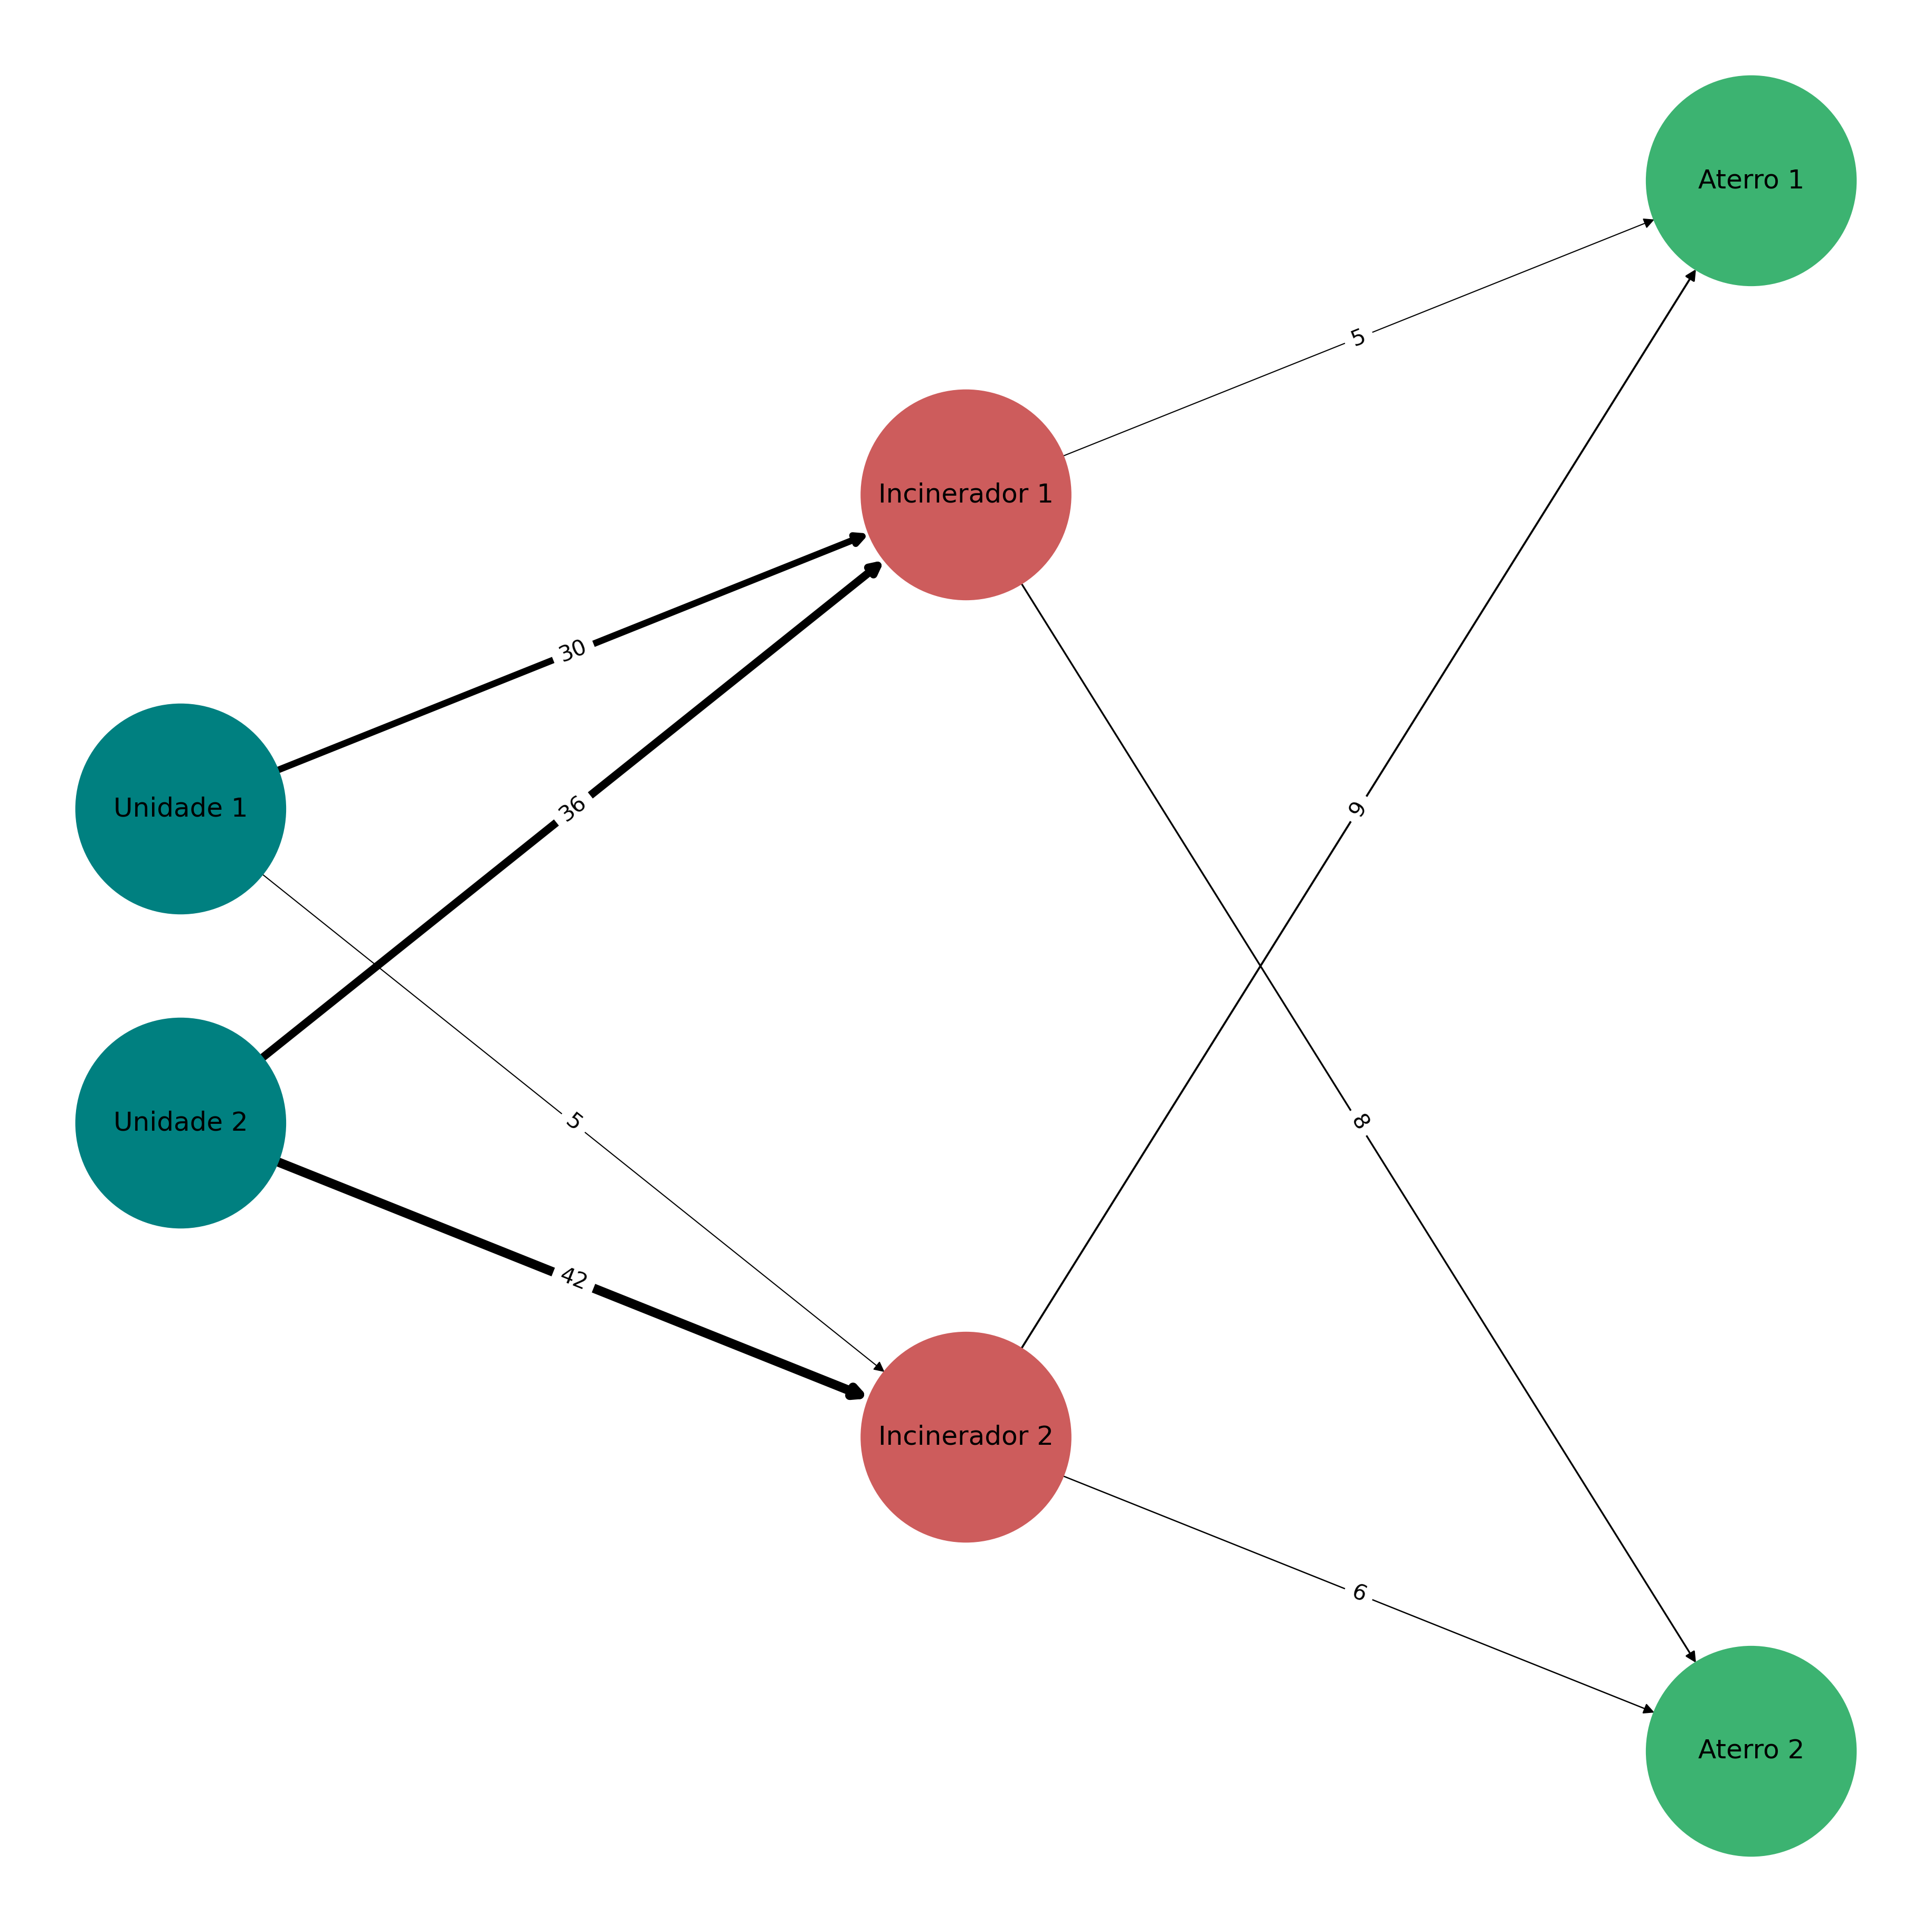

In [3]:
from plot import *
create_graph()

Esse problema nos traz um problema de minimização de custo. Seja $x_i^j$ uma variável que guarda a quantidade de toneladas que vai da unidade $i$ para incinerador $j$ e seja $y_i^j$ uma varíavel que guarda a quantidade que vai do incinerador $i$ para o Aterro $j$. Temos o custo:
$$
min C = 40*(x_1^1 +x_2^1) + 30*(x_1^2 +x_2^2) + 3*(30*x_1^1+5*x_1^2+36*x_2^1+42*x_2^2+5*y_1^1+8*y_1^2+9y_2^1+6y_2^2)
$$
$$
min C = 130*x_1^1 + 55*x_1^2 +148x_2^1 +166*x_2^2 + 15*y_1^1+24*y_1^2+27y_2^1+18y_2^2
$$
Dadas as seguintes restrições:
$$
x_1^1 +x_1^2 = 500
$$
$$
x_2^1 +x_2^2 = 400
$$
$$
\frac{x_1^1 +x_2^1}{5} -y_1^1 - y_1^2 = 0  
$$
$$
\frac{x_1^2 +x_2^2}{5} -y_2^1 -y_2^2 = 0
$$
$$
x_1^1 +x_2^1 \leq 500
$$
$$
x_1^2 +x_2^2 \leq 500
$$
$$
y_1^1 +y_2^1 \leq 200
$$
$$
y_1^2 +y_2^2 \leq 200
$$
$$
x_1^1,x_1^2,x_2^1,x_2^2,y_1^1,y_1^2,y_2^1,y_2^2 \geq 0 
$$

In [4]:
import pyomo.environ as pyEnv
import numpy as np

In [6]:
cost = [130,55,148,166,15,24,27,18]
demandas = [500,400,0,0,500,500,200,200]
padrao = np.array([
    [1,1,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0],
    [1/5,0,1/5,0,-1,-1,0,0],
    [0,1/5,0,1/5,0,0,-1,-1],
    [1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,0],
    [0,0,0,0,1,0,1,0],
    [0,0,0,0,0,1,0,1]
])

modelo = pyEnv.ConcreteModel()
modelo.Indices = range(len(cost))
modelo.Indices2 = range(len(demandas))

modelo.x = pyEnv.Var(
    modelo.Indices, 
    within = pyEnv.NonNegativeReals
)

modelo.Objetivo = pyEnv.Objective(
    expr = sum(modelo.x[i]*j for i,j in zip(modelo.Indices,cost)),
    sense = pyEnv.minimize
)
def restricao(modelo, i):
    if(i<=3):
        return sum(padrao[i][j]*modelo.x[j] for j in modelo.Indices) == demandas[i]
    return sum(padrao[i][j]*modelo.x[j] for j in modelo.Indices) <= demandas[i]

##Note que para cada valor em modelo.Indices2 será criada uma restrição,
##em que o índice i na função restricao assumirá um valor em modelo.Indices2
modelo.rest = pyEnv.Constraint(modelo.Indices2, rule = restricao)

In [7]:
solver = pyEnv.SolverFactory('cbc')
result_objetivo = solver.solve(modelo)

In [21]:
from rich import print
from rich.table import Table

lista = list(modelo.x.keys())
t = Table(
    title = 'Resumo Variáveis e Custo do Modelo',
)
t.add_column('Variáveis',justify = 'center')
t.add_column('Valores',justify = 'center')
a = [
    r"x₁¹",r'x₁²',r'x₂¹',r'x₂²',r'y₁¹',r'y₁²',r'y₂¹',r'y₂²'
]
for i in list(enumerate(a)):
    t.add_row(str(i[1]),str(modelo.x[i[0]]()))
t.add_row('Custo',str(modelo.Objetivo()))
print(t)

  Resumo Variáveis e   
    Custo do Modelo    
┏━━━━━━━━━━━┳━━━━━━━━━┓
┃ Variáveis ┃ Valores ┃
┡━━━━━━━━━━━╇━━━━━━━━━┩
│    x₁¹    │   0.0   │
│    x₁²    │  500.0  │
│    x₂¹    │  400.0  │
│    x₂²    │   0.0   │
│    y₁¹    │  80.0   │
│    y₁²    │   0.0   │
│    y₂¹    │   0.0   │
│    y₂²    │  100.0  │
│   Custo   │ 89700.0 │
└───────────┴─────────┘